
# California Housing — Correlación, Información Mutua y Entropía Condicional

Este notebook:
1. Carga el dataset **California Housing** de `sklearn`.
2. Calcula y **visualiza** la **matriz de correlación (Pearson)** con `matplotlib` (sin `seaborn`).
3. Calcula la **información mutua** entre cada variable y el objetivo usando `mutual_info_regression`.
4. **Demuestra** el concepto de **entropía condicional** mediante **discretización** (con advertencias) y la compara con la MI estimada por `sklearn`.

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import mutual_info_regression

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


## 1) Carga del dataset

In [2]:

# Cargar California Housing
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

# Renombrar la columna objetivo a algo más claro (ya es 'MedHouseVal' en este dataset)
target_col = 'MedHouseVal'
feature_cols = [c for c in df.columns if c != target_col]

df.shape, df.head()


((20640, 9),
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0  8.3252   41.0000    6.9841     1.0238    322.0000    2.5556   37.8800   
 1  8.3014   21.0000    6.2381     0.9719  2,401.0000    2.1098   37.8600   
 2  7.2574   52.0000    8.2881     1.0734    496.0000    2.8023   37.8500   
 3  5.6431   52.0000    5.8174     1.0731    558.0000    2.5479   37.8500   
 4  3.8462   52.0000    6.2819     1.0811    565.0000    2.1815   37.8500   
 
    Longitude  MedHouseVal  
 0  -122.2300       4.5260  
 1  -122.2200       3.5850  
 2  -122.2400       3.5210  
 3  -122.2500       3.4130  
 4  -122.2500       3.4220  )

## 2) Correlación (Pearson)

In [3]:

# Matriz de correlación (Pearson) entre TODAS las columnas
corr = df.corr(numeric_only=True, method='pearson')

# Mostrar tabla ordenando por correlación con el target
corr_with_target = corr[target_col].drop(target_col).sort_values(ascending=False).to_frame('pearson_with_target')
corr_with_target


,pearson_with_target
MedInc,0.6881
AveRooms,0.1519
HouseAge,0.1056
AveOccup,-0.0237
Population,-0.0246
Longitude,-0.0460
AveBedrms,-0.0467
Latitude,-0.1442


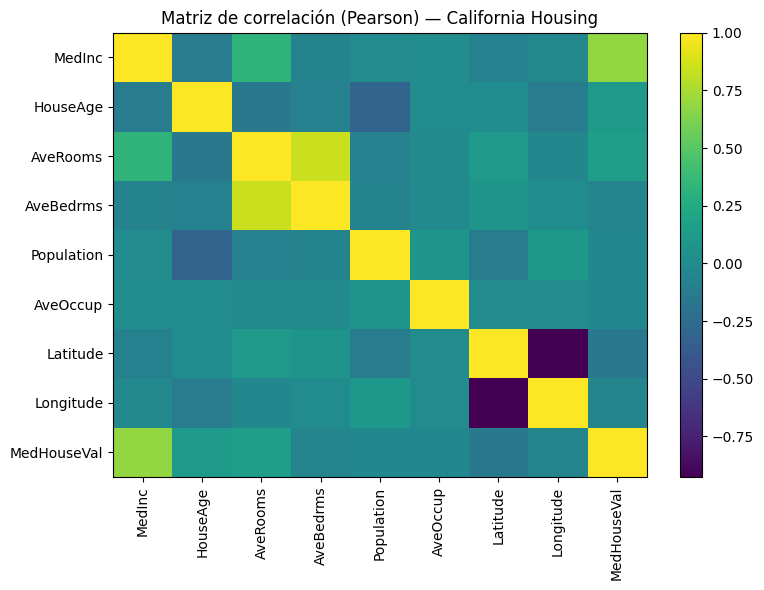

In [11]:

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(corr.values, aspect='auto')
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.title('Matriz de correlación (Pearson) — California Housing')
plt.tight_layout()
plt.show()


## 3) Información mutua con el objetivo (`mutual_info_regression`)

In [5]:

# Preparar X (features) y y (objetivo)
X = df[feature_cols].values
y = df[target_col].values

# mutual_info_regression: estima MI(X_i, y) para cada variable X_i continua respecto a y continua
# Usa un estimador k-NN (vecinos más cercanos). Establecemos random_state para reproducibilidad.
mi = mutual_info_regression(X, y, random_state=42)

mi_series = pd.Series(mi, index=feature_cols, name='mi_with_target').sort_values(ascending=False)
mi_series.to_frame()


,mi_with_target
Longitude,0.4001
MedInc,0.3871
Latitude,0.3708
AveRooms,0.1029
AveOccup,0.0727
HouseAge,0.0334
AveBedrms,0.0241
Population,0.0209


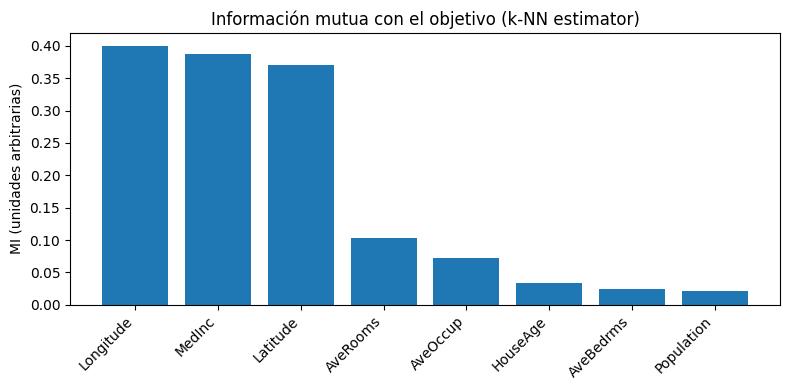

In [6]:

# Visualización de MI (matplotlib puro)
fig = plt.figure(figsize=(8, 4))
plt.bar(mi_series.index, mi_series.values)
plt.title('Información mutua con el objetivo (k-NN estimator)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MI (unidades arbitrarias)')
plt.tight_layout()
plt.show()



## 4) Entropía condicional (aproximación por discretización) y comparación cualitativa

Demostración del concepto de entropía condiciona con binning discreto (p. ej., cuantiles). Cambiar el número/estrategia de bins cambia los valores.


In [7]:

def entropy_from_counts(counts):
    p = counts / counts.sum()
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def entropy_discrete(series_binned):
    vals, counts = np.unique(series_binned, return_counts=True)
    return entropy_from_counts(counts)

def conditional_entropy_discrete(y_binned, x_binned):
    # H(Y|X) = sum_x p(x) * H(Y|X=x)
    H = 0.0
    x_vals, x_counts = np.unique(x_binned, return_counts=True)
    total = len(x_binned)
    for xv, xc in zip(x_vals, x_counts):
        mask = (x_binned == xv)
        y_vals, y_counts = np.unique(y_binned[mask], return_counts=True)
        H += (xc / total) * entropy_from_counts(y_counts)
    return H

def discretize_series(s, n_bins=10, strategy='quantile'):
    s = pd.Series(s).astype(float)
    if strategy == 'quantile':
        # qcut puede fallar con duplicados en bordes; usar duplicates='drop'
        return pd.qcut(s, q=min(n_bins, s.nunique()), duplicates='drop')
    elif strategy == 'uniform':
        return pd.cut(s, bins=n_bins)
    else:
        raise ValueError("strategy must be 'quantile' or 'uniform'")


In [8]:

# Discretización (ilustrativa) del objetivo y de cada feature en cuantiles
n_bins = 10
y_bin = discretize_series(df[target_col], n_bins=n_bins, strategy='quantile')

rows = []
for col in feature_cols:
    x_bin = discretize_series(df[col], n_bins=n_bins, strategy='quantile')
    H_y = entropy_discrete(y_bin)
    H_y_given_x = conditional_entropy_discrete(y_bin, x_bin)
    mi_discrete = H_y - H_y_given_x  # I(X_bin; Y_bin)
    rows.append({
        'feature': col,
        'H(Y)_discrete_bits': H_y,
        'H(Y|X)_discrete_bits': H_y_given_x,
        'MI_discrete_bits': mi_discrete
    })

ce_df = pd.DataFrame(rows).set_index('feature').sort_values('MI_discrete_bits', ascending=False)
ce_df


,H(Y)_discrete_bits,H(Y|X)_discrete_bits,MI_discrete_bits
feature,,,
MedInc,3.3219,2.8492,0.4727
Longitude,3.3219,3.0970,0.2249
Latitude,3.3219,3.1276,0.1943
AveRooms,3.3219,3.2115,0.1104
AveOccup,3.3219,3.2336,0.0883
HouseAge,3.3219,3.2915,0.0304
AveBedrms,3.3219,3.2963,0.0256
Population,3.3219,3.3023,0.0196


## 5) Comparación (cualitativa) entre MI k-NN y MI discreta (binned)

In [9]:

# Unir los resultados de MI k-NN y MI discreta (para ver ordenamientos)
compare = pd.concat([
    mi_series.rename('MI_kNN'),
    ce_df['MI_discrete_bits']
], axis=1).sort_values('MI_kNN', ascending=False)

compare


,MI_kNN,MI_discrete_bits
Longitude,0.4001,0.2249
MedInc,0.3871,0.4727
Latitude,0.3708,0.1943
AveRooms,0.1029,0.1104
AveOccup,0.0727,0.0883
HouseAge,0.0334,0.0304
AveBedrms,0.0241,0.0256
Population,0.0209,0.0196



## 6) Conclusiones

- **Correlación (Pearson)** capta **relaciones lineales** y es sensible a **outliers**.
- **Información Mutua (k-NN)** captura **dependencias no lineales** entre cada `feature` y el objetivo `MedHouseVal`.
- La **entropía condicional** para continuas **no** está disponible directamente en `sklearn` y requiere **estimación de densidades**; aquí usamos **binning** para ilustrar el concepto, pero los valores dependen del número/estrategia de bins.
- Use **correlación** para una primera vista rápida; compleméntela con **MI** para descubrir dependencias no lineales.
